In [1]:
# Download the dataset from Kaggle using the below code.
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tongpython/cat-and-dog
!ls
!unzip cat-and-dog.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  inflating: training

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import resnet18
import cv2, numpy as np
!pip install -q torch_summary
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
from glob import glob
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = resnet18(pretrained=True)
summary(model,input_size=(3,224,224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

In [4]:
class CatDogDS(Dataset):
  def __init__(self,folder):
    dogs = glob(folder+'/dogs/*.jpg')
    cats = glob(folder+'/cats/*.jpg')
    self.fpaths = dogs[:500] + cats[:500]
    from random import shuffle, seed; seed(10)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
    self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229,0.224,0.225])
  def __len__(self): return len(self.fpaths)
  def __getitem__(self,ix):
    target = self.targets[ix]
    f = self.fpaths[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im,(224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = self.normalize(im)
    return im.float().to(device), torch.tensor([target]).float().to(device)

trn_dir = '/content/training_set/training_set'
val_dir = '/content/test_set/test_set'

In [5]:
def get_data():
  train = CatDogDS(trn_dir)
  trn_dl = DataLoader(train,batch_size=32,shuffle=True,drop_last=True)

  val = CatDogDS(val_dir)
  val_dl = DataLoader(val,batch_size=32,shuffle=True,drop_last=True)
  return trn_dl, val_dl

trn_dl, val_dl = get_data()

In [6]:
def get_model():
  model = resnet18(pretrained=True)
  for params in model.parameters():
    params.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.fc = nn.Sequential(
      nn.Linear(512,128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128,1),
      nn.Sigmoid()
  )
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
  return model.to(device), loss_fn, optimizer

model, loss_fn, optimizer = get_model()

In [7]:
def train_batch(img,target,model,loss_fn,optimizer):
  model.train()
  prediction = model(img)
  loss = loss_fn(prediction,target)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return loss.item()

@torch.no_grad()
def accuracy(img,target,model):
  model.eval()
  prediction = model(img)
  acc = (prediction > 0.5) == target
  return acc.cpu().numpy().tolist()

In [8]:
train_losses, train_accuracies = [], []
val_accuracies = []

for epoch in range(5):
  print(f'{1+epoch}/5 in pregress')
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies= []

  for ix, batch in enumerate(iter(trn_dl)):
    img, target = batch
    batch_loss = train_batch(img,target,model,loss_fn,optimizer)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    img, target = batch
    trn_acc = accuracy(img,target,model)
    train_epoch_accuracies.extend(trn_acc)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    img, target = batch
    val_acc = accuracy(img,target,model)
    val_epoch_accuracies.extend(val_acc)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)


1/5 in pregress
2/5 in pregress
3/5 in pregress
4/5 in pregress
5/5 in pregress


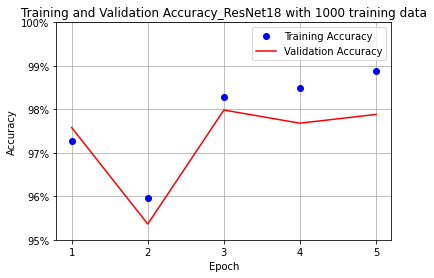

In [9]:
epochs = np.arange(5) + 1
plt.plot(epochs,train_accuracies,'bo',label='Training Accuracy')
plt.plot(epochs,val_accuracies,'r',label='Validation Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and Validation Accuracy_ResNet18 with 1000 training data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()